<a href="https://colab.research.google.com/github/harshit-kr-dubey/market-research-/blob/main/marketresearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import logging
import sqlite3

In [2]:
logging .basicConfig(format='%(levelname)s: %(message)s', level = logging.DEBUG)

Extract sources

In [3]:
def extract(source):
    data = pd.read_csv(source)

    logging.debug(f'{source} has been extracted')
    logging.info(f'There are {data.shape[0]} rows and {data.shape[1]} columns')
    return data

In [4]:
def transform(apps, reviews, category, min_rating, min_reviews):
    logging.info(f'Tranforming data to create a dataset with all {category} apps and their corresponding reviews with a rating of at least {min_rating} and {min_reviews} reviews')

    # Drop duplicates
    dropped_apps = apps.drop_duplicates(['App'])
    dropped_reviews = reviews.drop_duplicates()

    # Filter 2 dataframes so that only the specific category is left
    dropped_apps = dropped_apps.loc[dropped_apps['Category'] == category]
    dropped_reviews = dropped_reviews.loc[dropped_reviews['App'].isin(dropped_apps['App']),['App','Sentiment_Polarity']]

    # Aggregate the reviews dataframe
    # Sentiment_Polarity: on averahe how extreme are the reviews
    agg_reviews = dropped_reviews.groupby('App').mean()

    # Join 2 dataframes
    joined_df = dropped_apps.merge(agg_reviews, on = 'App', how = 'left')

    # Filter columns
    filtered_df = joined_df[['App','Rating','Reviews','Installs','Sentiment_Polarity']]

    # type conversion
    # dtypes for Reviews is Object(string), need to convert into int
    filtered_df = filtered_df.astype({'Reviews':'int32'})

    # filter according minimum rating and minimum reviews
    result = filtered_df.loc[(filtered_df['Rating'] > min_rating) & (filtered_df['Reviews'] > min_reviews)]
    result.sort_values(by = ['Rating','Reviews'], ascending = False, inplace = True)
    result.reset_index(drop = True, inplace = True)

    # Persist result Dataframe
    result.to_csv('result.csv')

    logging.debug(f'The transformed dataframe has {result.shape[0]} rows and {result.shape[1]} columns. It has been persisted as result.csv file.')
    return result

In [5]:
# Load dataframe into a SQL database
def load(dataframe, database_name, table_name):
    con = sqlite3.connect(database_name)

    dataframe.to_sql(name = table_name, con = con, if_exists = 'replace', index = False)
    loaded_df = pd.read_sql(f'SELECT * FROM {table_name}', con = con)

    try:
        assert loaded_df.shape == dataframe.shape
        print('Success!')

    except AssertionError:
        print('Failed! There is something wrong')

transformed_df = transform(extract('apps_data.csv'),extract('review_data.csv'),'FOOD_AND_DRINK',4.0,1000)
load(dataframe = transformed_df, database_name = 'market_research', table_name = 'top_apps')

Success!


/tmp/ipython-input-4-3004017570.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.sort_values(by = ['Rating','Reviews'], ascending = False, inplace = True)


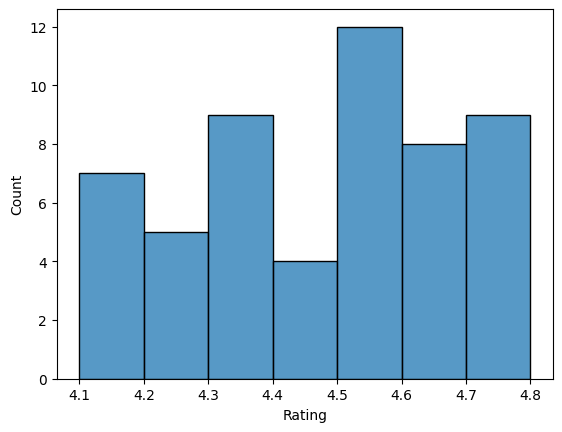

In [6]:

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('result.csv')
sns.histplot(df['Rating'])
plt.show()


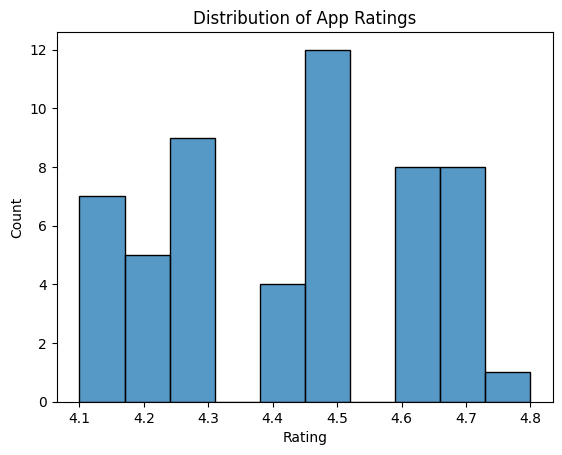

In [7]:
sns.histplot(df['Rating'], bins=10)
plt.title('Distribution of App Ratings')
plt.show()


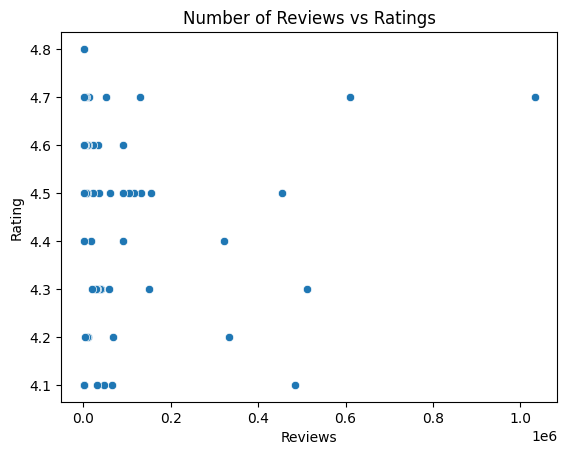

In [8]:
sns.scatterplot(data=df, x='Reviews', y='Rating')
plt.title('Number of Reviews vs Ratings')
plt.show()


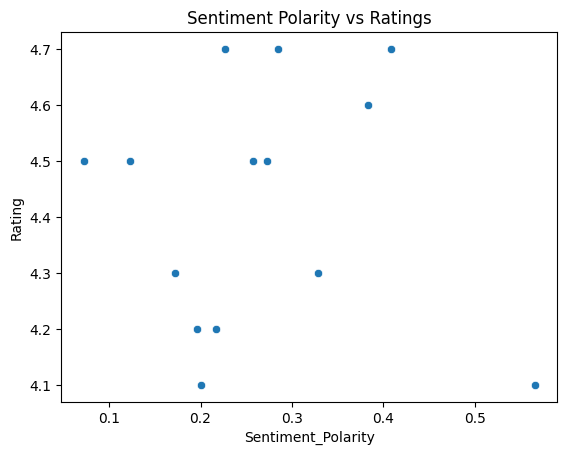

In [9]:
sns.scatterplot(data=df, x='Sentiment_Polarity', y='Rating')
plt.title('Sentiment Polarity vs Ratings')
plt.show()


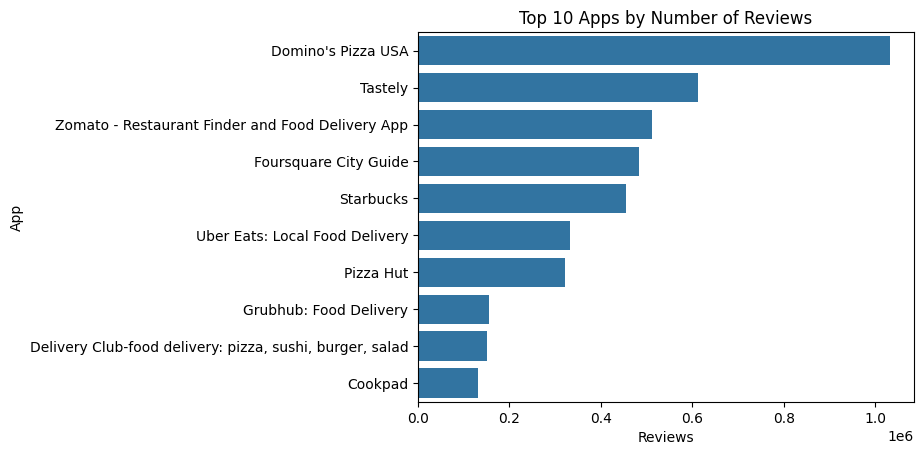

In [10]:
top_apps = df.nlargest(10, 'Reviews')
sns.barplot(data=top_apps, x='Reviews', y='App')
plt.title('Top 10 Apps by Number of Reviews')
plt.show()


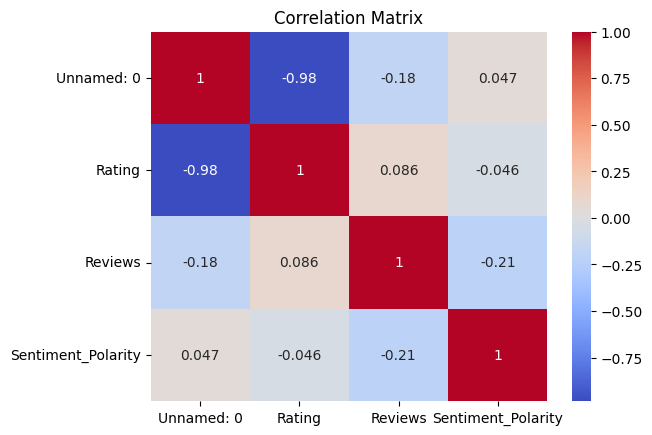

In [13]:
numeric_df=df.select_dtypes(include='number')
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
